In [54]:
!pip install joblib

    100% |################################| 184kB 2.9MB/s 


In [2]:
import google.cloud.storage as gcs
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import joblib
import seaborn as sns
from datetime import datetime as dt
from sklearn.metrics import roc_curve, auc, f1_score, average_precision_score, precision_recall_curve, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
matplotlib.use('Agg')
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
palette = sns.color_palette("Set2", 10)
sns.set_palette(palette)
modelnames = ['LSTM', 'Random Forest', 'Logistic Regression']

font = {'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)
sns.set_style('whitegrid')

## LSTMs vs. Baselines

In [4]:
client = gcs.Client('user-lifecycle')
bucket = gcs.Bucket(client, 'helder')

In [5]:
models = ['lstm', 'rf', 'lr']
prec_recs = []
pr_aucs = []
f1s = []
confusions = []
roc_aucs =  []
fpr_tprs = []
cvs = []
th_metrics = []

for model in models:
  blob = gcs.Blob(name='churnr/temporal_static/56_30d/{}/y_test_true_pred.gz'.format(model), bucket=bucket)
  predpath = '/tmp/{}_y_test_true_pred.gz'.format(model)
  cvpath = '/tmp/{}_cv_results.csv'.format(model)
  with open(predpath, 'wb') as f:
      blob.download_to_file(f)
  blob = gcs.Blob(name='churnr/temporal_static/56_30d/{}/cv_results.csv'.format(model), bucket=bucket)
  with open(cvpath, 'wb') as f:
      blob.download_to_file(f)

  y_trpred = joblib.load(predpath)
  y_true = y_trpred[:,0]
  y_pred = y_trpred[:,1]
  y_true_ret = 1.0 - y_true 
  y_pred_ret = 1.0 - y_pred
  
  # calculate PR AUC
  prec, rec, thresholds = precision_recall_curve(y_true, y_pred)
  pr_auc = average_precision_score(y_true, y_pred)
  pr_auc_ret = average_precision_score(y_true_ret, y_pred_ret)
  
  # calculate some metrics by thresholding to 0.5, maybe it would be smarter to use on of the thresholds
  #   returned by precision_recall_curve()
  y_pred_th = np.array([0.0 if i <= 0.5 else 1.0 for i in y_pred])
  f1 = f1_score(y_true, y_pred_th)  
  prec_th, rec_th, fbeta_th, supp_th = precision_recall_fscore_support(y_true, y_pred_th)
  
  # calculate the confusion matrix
  cfm = confusion_matrix(y_true, y_pred_th)
  
  # calculate ROC curve and ROC AUC
  fpr, tpr, _ = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  
  # load CV results
  cv = pd.read_csv(cvpath)
  
  pr_aucs.append(pr_auc)
  prec_recs.append((prec, rec))  
  f1s.append(f1)
  confusions.append(cfm)
  roc_aucs.append(roc_auc)
  fpr_tprs.append((fpr, tpr))
  cvs.append(cv)
  th_metrics.append((prec_th, rec_th, fbeta_th, (pr_auc_ret, pr_auc)))

### Precision-Recall Curves



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://prc_temporal_static.pdf [Content-Type=application/pdf]...
-
Operation completed over 1 objects/108.3 KiB.                                    


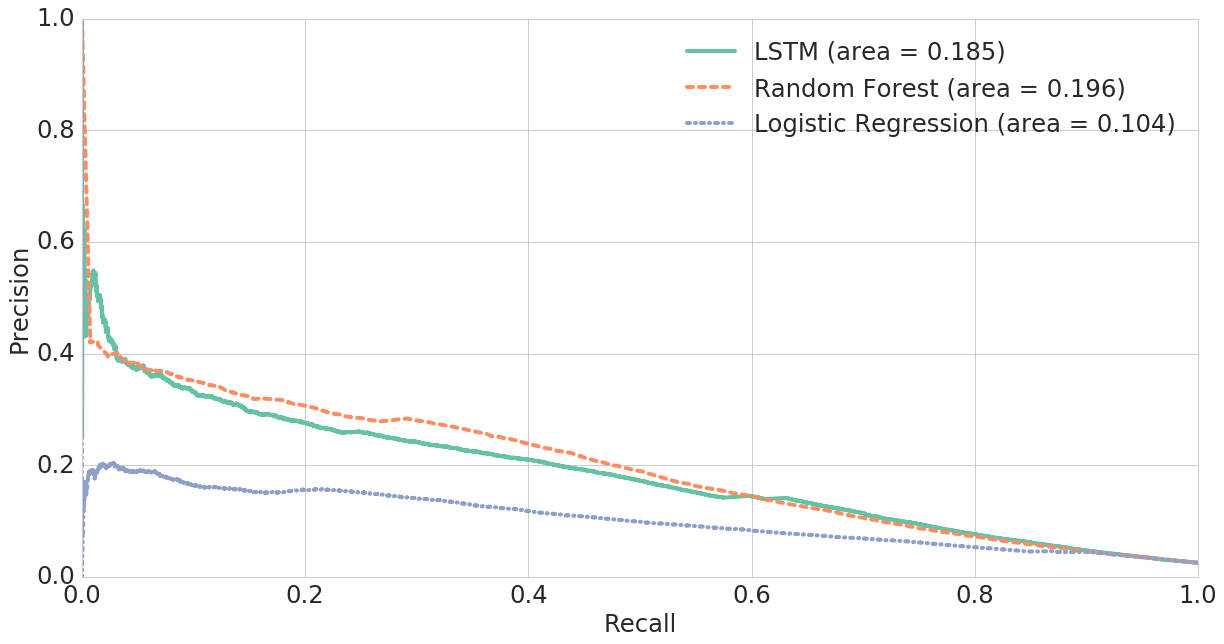

In [6]:
fig, ax = plt.subplots(nrows=1, figsize=(20,10))

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall', fontsize='xx-large')
ax.set_ylabel('Precision', fontsize='xx-large')
#ax.set_title('Precision-Recall curves, `Churned` class', fontsize='xx-large')

linestyles = ['-', '--', '-.']*len(prec_recs)
for prec_rec, pr_auc, model, f1, ls in zip(prec_recs, pr_aucs, modelnames, f1s, linestyles):
  prec = prec_rec[0]
  rec = prec_rec[1]
  ax.plot(rec, prec, linewidth=4.0, linestyle=ls, dash_capstyle='round', label='{0} (area = {1:.3f})'.format(model, pr_auc))
ax.tick_params(labelsize='xx-large')
ax.legend(fontsize='xx-large')

plt.savefig('prc_temporal_static.pdf', bbox_inches='tight')
!gsutil cp 'prc_temporal_static.pdf' 'gs://helder/churnr/plots/prc_temporal_static.pdf'

### Confusion Matrices

Copying file://cfm_temporal_static.pdf [Content-Type=application/pdf]...
/ [1 files][ 13.9 KiB/ 13.9 KiB]                                                
Operation completed over 1 objects/13.9 KiB.                                     


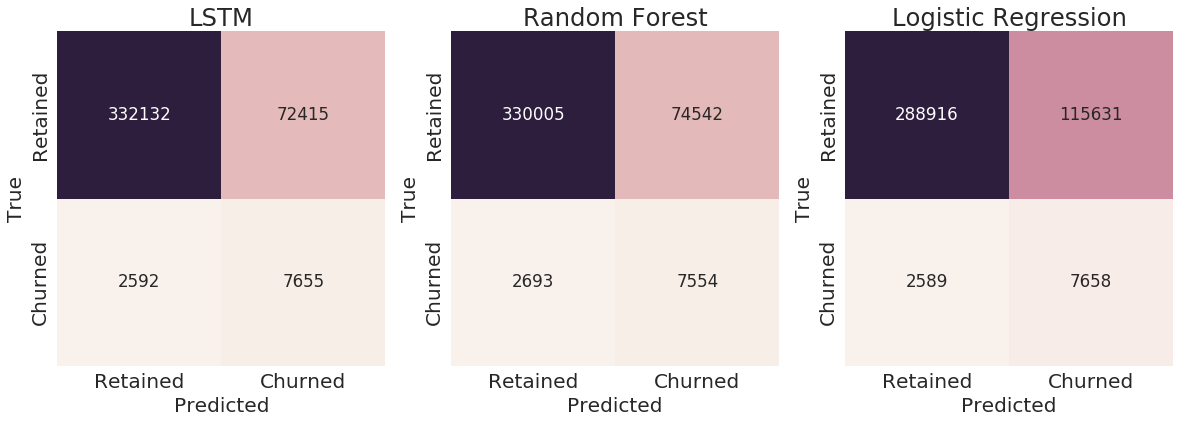

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
axs = axs.reshape((1,3))[0]
for cnf, title, ax in zip(confusions, modelnames, axs):
  cnf_n = cnf.astype('float') / cnf.sum(axis=1)[:, np.newaxis]
  sns.heatmap(cnf, annot=True, annot_kws={'fontsize': 'large'}, cbar=False, ax=ax, xticklabels=['Retained', 'Churned'], yticklabels=['Retained', 'Churned'], fmt="d")
  ax.set_title(title, fontsize='xx-large')
  ax.set_xlabel('Predicted', fontsize='x-large')
  ax.set_ylabel('True', fontsize='x-large')
  ax.tick_params(labelsize='x-large')
  
plt.savefig('cfm_temporal_static.pdf', bbox_inches='tight')
!gsutil cp 'cfm_temporal_static.pdf' 'gs://helder/churnr/plots/cfm_temporal_static.pdf'

### ROC Curves

Copying file://roc_temporal_static.pdf [Content-Type=application/pdf]...
/ [1 files][ 81.2 KiB/ 81.2 KiB]                                                
Operation completed over 1 objects/81.2 KiB.                                     


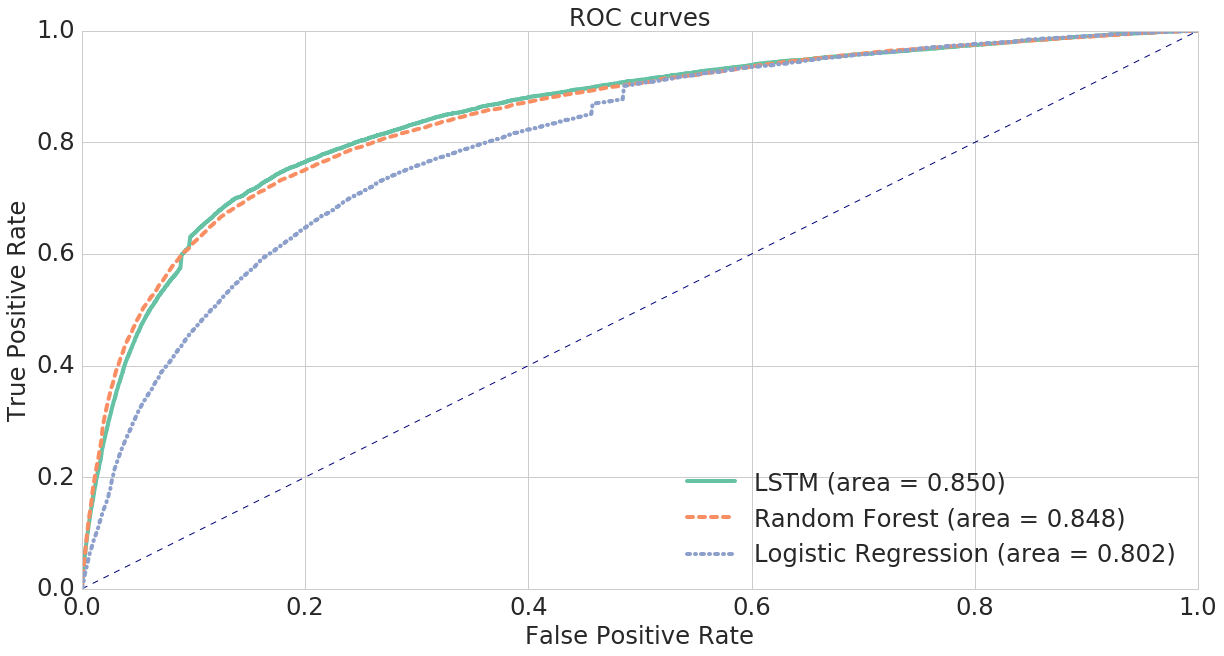

In [83]:
fig, ax = plt.subplots(nrows=1, figsize=(20,10))

ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate', fontsize='xx-large')
ax.set_ylabel('True Positive Rate', fontsize='xx-large')
ax.set_title('ROC curves', fontsize='xx-large')

linestyles = ['-', '--', '-.']
for fpr_tpr, roc_auc, label, ls in zip(fpr_tprs, roc_aucs, modelnames, linestyles):
  fpr = fpr_tpr[0]
  tpr = fpr_tpr[1]
  ax.plot(fpr, tpr, linewidth=4.0, linestyle=ls, dash_capstyle='round', label='{0} (area = {1:.3f})'.format(label, roc_auc))
ax.legend(fontsize='xx-large', loc='best')
ax.tick_params(labelsize='xx-large')

plt.savefig('roc_temporal_static.pdf', bbox_inches='tight')
!gsutil cp 'roc_temporal_static.pdf' 'gs://helder/churnr/plots/roc_temporal_static.pdf'

### Accuracy

Copying file://acc_temporal_static.pdf [Content-Type=application/pdf]...
/ [1 files][ 13.0 KiB/ 13.0 KiB]                                                
Operation completed over 1 objects/13.0 KiB.                                     


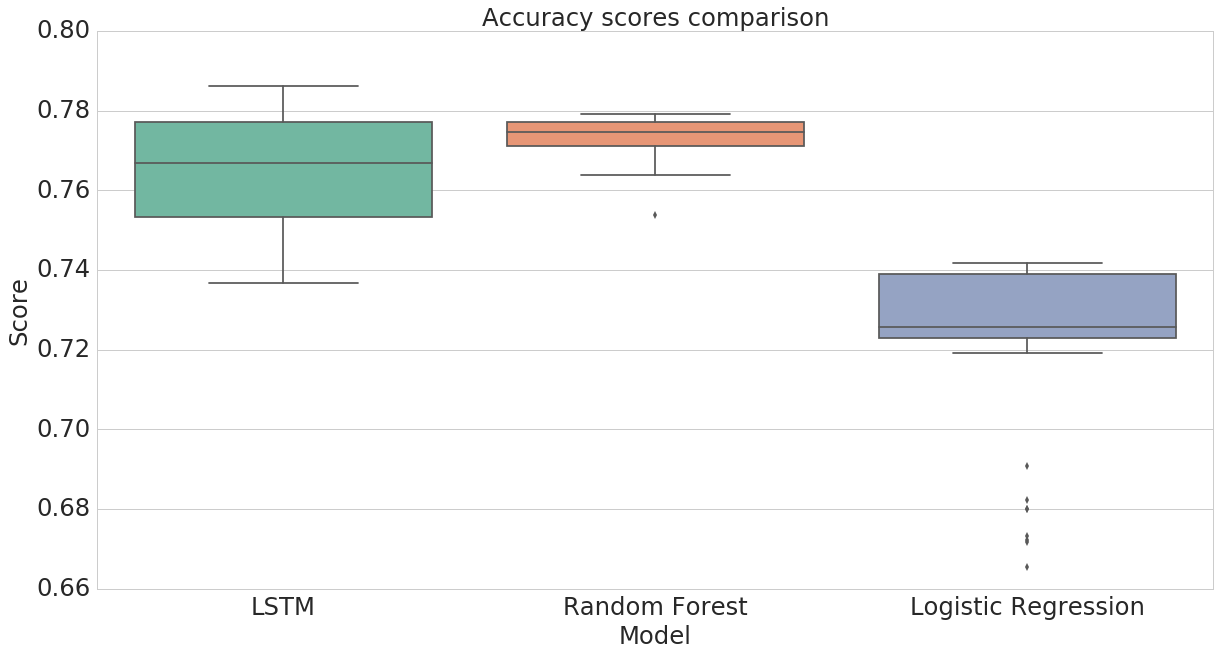

In [84]:
dfs = []
for cv, model in zip(cvs, modelnames):
  df = pd.DataFrame(cv.mean_test_score)
  df['model'] = model
  dfs.append(df)
dfs = pd.concat(dfs)

fig, ax = plt.subplots(nrows=1, figsize=(20,10))
ax.set_title('Accuracy scores comparison', fontsize='xx-large')
sns.boxplot(x='model', y='mean_test_score', data=dfs, ax=ax)
ax.set_xlabel('Model', fontsize='xx-large')
ax.set_ylabel('Score', fontsize='xx-large')
ax.tick_params(labelsize='xx-large')

plt.savefig('acc_temporal_static.pdf', bbox_inches='tight')
!gsutil cp 'acc_temporal_static.pdf' 'gs://helder/churnr/plots/acc_temporal_static.pdf'

### Overall scores

In [89]:
dfs = []
for metric, model in zip(th_metrics, modelnames):
  vals = {'Precision': metric[0], 'Recall': metric[1], 'F1-Score': metric[2], 'PR AUC': metric[3]}
  df = pd.DataFrame(vals, index=['Retained','Churned'])
  dfs.append(df)
dfs = pd.concat(dfs, keys=modelnames)
#dfs
print(dfs.to_latex(multirow=True))

\begin{tabular}{llrrrr}
\toprule
     &          &  F1-Score &    PR AUC &  Precision &    Recall \\
\midrule
\multirow{2}{*}{LSTM} & Retained &  0.898539 &  0.994353 &   0.992256 &  0.820997 \\
     & Churned &  0.169514 &  0.184844 &   0.095604 &  0.747048 \\
\cline{1-6}
\multirow{2}{*}{Random Forest} & Retained &  0.895238 &  0.994219 &   0.991906 &  0.815740 \\
     & Churned &  0.163607 &  0.196442 &   0.092014 &  0.737191 \\
\cline{1-6}
\multirow{2}{*}{Logistic Regression} & Retained &  0.830156 &  0.992835 &   0.991119 &  0.714172 \\
     & Churned &  0.114696 &  0.103541 &   0.062114 &  0.747341 \\
\bottomrule
\end{tabular}

